### 위도와 경도를 가지고 위치를 찾는 함수인데 저는 이거 할줄 몰라서 GPT 돌렸습니다.

In [ ]:
import math
import requests
from datetime import datetime, timedelta

# ✅ 1. 주소 → 위경도 변환 (Kakao Map API)
def get_latlon_from_kakao(address: str, kakao_key: str):
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {kakao_key}"}
    params = {"query": address}

    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"❌ [Kakao API 오류] 상태 코드 {response.status_code}")
        return None, None

    data = response.json()
    documents = data.get('documents', [])
    if not documents:
        print("❌ 주소 검색 결과 없음")
        return None, None

    y = float(documents[0]['y'])  # 위도
    x = float(documents[0]['x'])  # 경도
    return y, x

# ✅ 2. 위경도 → 기상청 격자 좌표 변환
def latlon_to_xy(lat: float, lon: float):
    RE = 6371.00877  # Earth radius (km)
    GRID = 5.0       # Grid spacing (km)
    SLAT1, SLAT2 = 30.0, 60.0
    OLON, OLAT = 126.0, 38.0
    XO, YO = 43, 136

    DEGRAD = math.pi / 180.0
    re = RE / GRID
    slat1 = SLAT1 * DEGRAD
    slat2 = SLAT2 * DEGRAD
    olon = OLON * DEGRAD
    olat = OLAT * DEGRAD

    sn = math.log(math.cos(slat1) / math.cos(slat2)) / \
         math.log(math.tan(math.pi * 0.25 + slat2 * 0.5) / math.tan(math.pi * 0.25 + slat1 * 0.5))
    sf = (math.tan(math.pi * 0.25 + slat1 * 0.5) ** sn * math.cos(slat1)) / sn
    ro = re * sf / (math.tan(math.pi * 0.25 + olat * 0.5) ** sn)
    
    ra = re * sf / (math.tan(math.pi * 0.25 + lat * DEGRAD * 0.5) ** sn)
    theta = lon * DEGRAD - olon
    if theta > math.pi: theta -= 2.0 * math.pi
    if theta < -math.pi: theta += 2.0 * math.pi
    theta *= sn

    x = int(ra * math.sin(theta) + XO + 0.5)
    y = int(ro - ra * math.cos(theta) + YO + 0.5)
    return x, y

# ✅ 3. 기상청 카테고리 코드 → 해석
def translate_category(category: str, value: str):
    category_map = {
        "SKY": {"1": "맑음", "3": "구름많음", "4": "흐림"},
        "PTY": {"0": "비나 눈이 안내림", "1": "비", "2": "비/눈", "3": "눈", "5": "빗방울", "6": "눈날림"}
    }
    return category_map.get(category, {}).get(value, value)

def category_label(category: str) -> str:
    label_map = {
        "SKY": "SKY(하늘형태)",
        "PTY": "PTY(강수형태)"
    }
    return label_map.get(category, category)

from collections import defaultdict

def get_weather(nx: int, ny: int, service_key: str):
    now = datetime.now()
    base_date = (now - timedelta(days=1)).strftime('%Y%m%d') if now.hour < 5 else now.strftime('%Y%m%d')
    base_time = "0500"

    url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    params = {
        "serviceKey": service_key,
        "pageNo": "1",
        "numOfRows": "500",  # 너무 많으면 출력 느려짐
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": nx,
        "ny": ny
    }

    try:
        response = requests.get(url, params=params, timeout=5)
        response.raise_for_status()
        data = response.json()
        items = data['response']['body']['items']['item']
    except (requests.exceptions.RequestException, KeyError):
        print("❌ 날씨 데이터를 불러오는 데 실패했습니다.")
        return

    # ✅ 시간별 SKY / PTY 분리 저장
    sky_map = defaultdict(str)
    pty_map = defaultdict(str)

    for item in items:

        # if item['fcstDate'] != base_date:
        #     continue # 오늘이 아닌 데이터는 건너뛰기 / 이거 비활성화 하면 2일치 날씨가 한시간 간격으로 보여져요
        
        time_key = f"{item['fcstDate']} {item['fcstTime']}"
        if item['category'] == "SKY":
            sky_map[time_key] = translate_category("SKY", item['fcstValue'])
        elif item['category'] == "PTY":
            pty_map[time_key] = translate_category("PTY", item['fcstValue'])

    print(f"✅ {base_date} 기준 {nx},{ny} 날씨 예보:")
    for time in sorted(sky_map.keys()):
        sky = sky_map.get(time, "-")
        pty = pty_map.get(time, "-")
        print(f"  - {time} | SKY(하늘형태) → {sky} | PTY(강수형태) → {pty}")



# 카카오맵 API 발급 받는 법

#

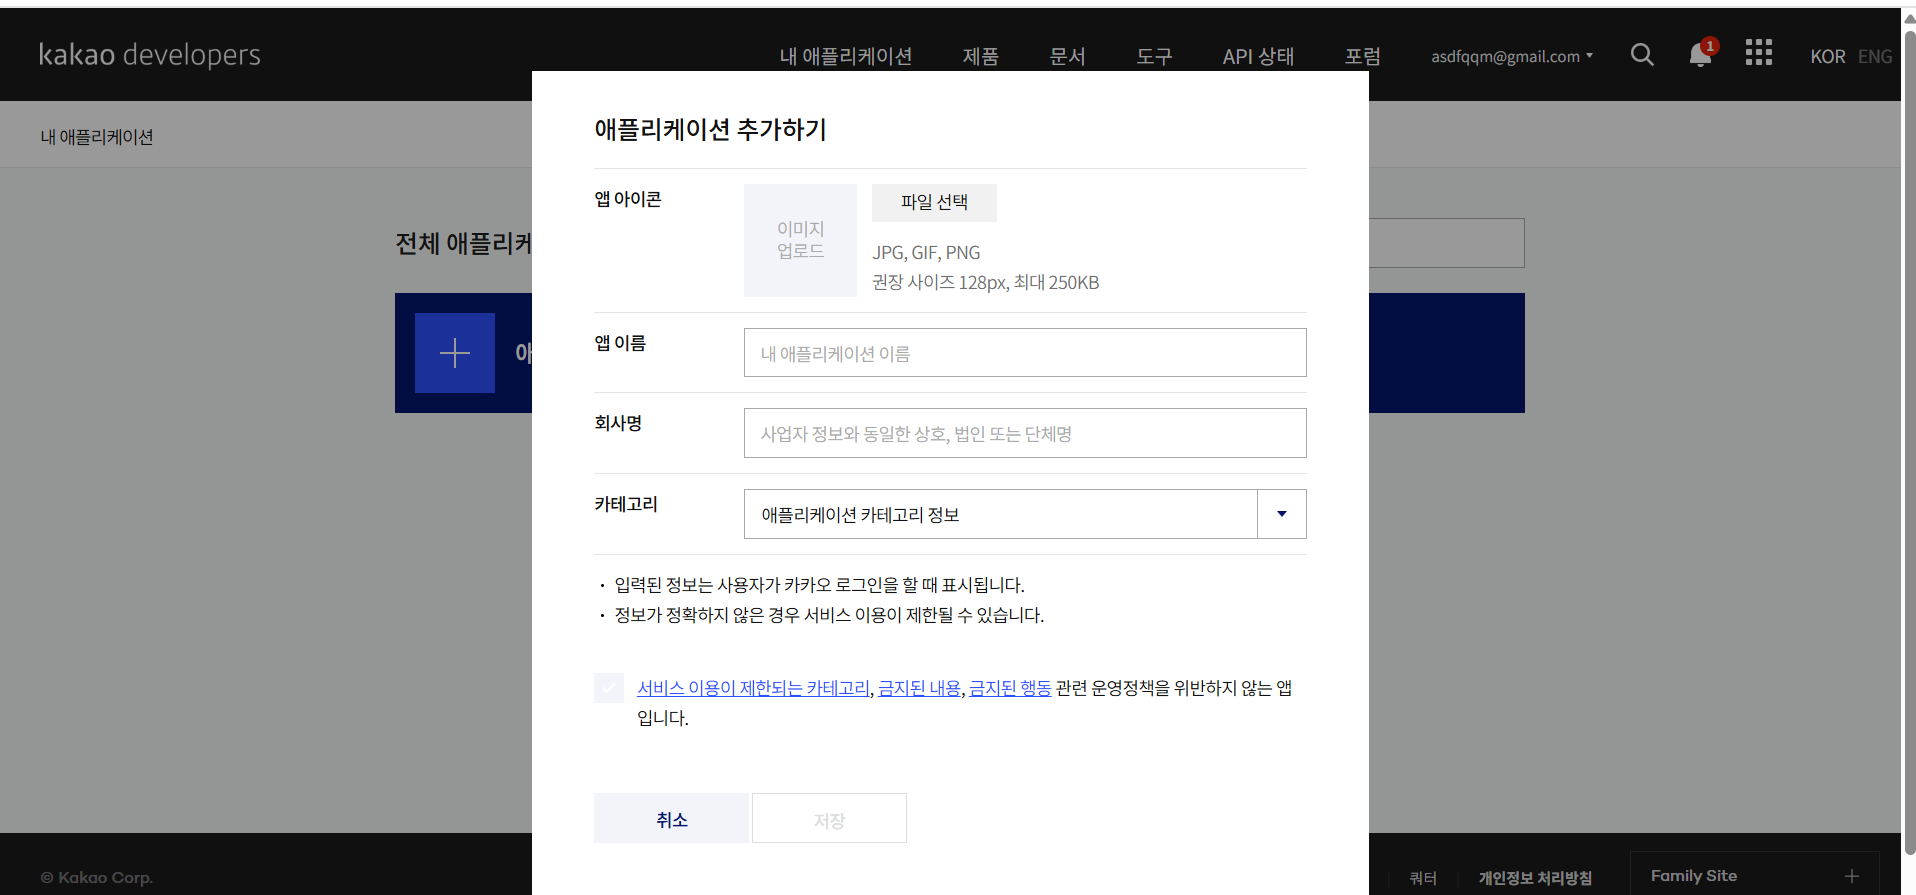

## 요렇게 뜨는데 아래 화면처럼 대충 입력하면 됩니다

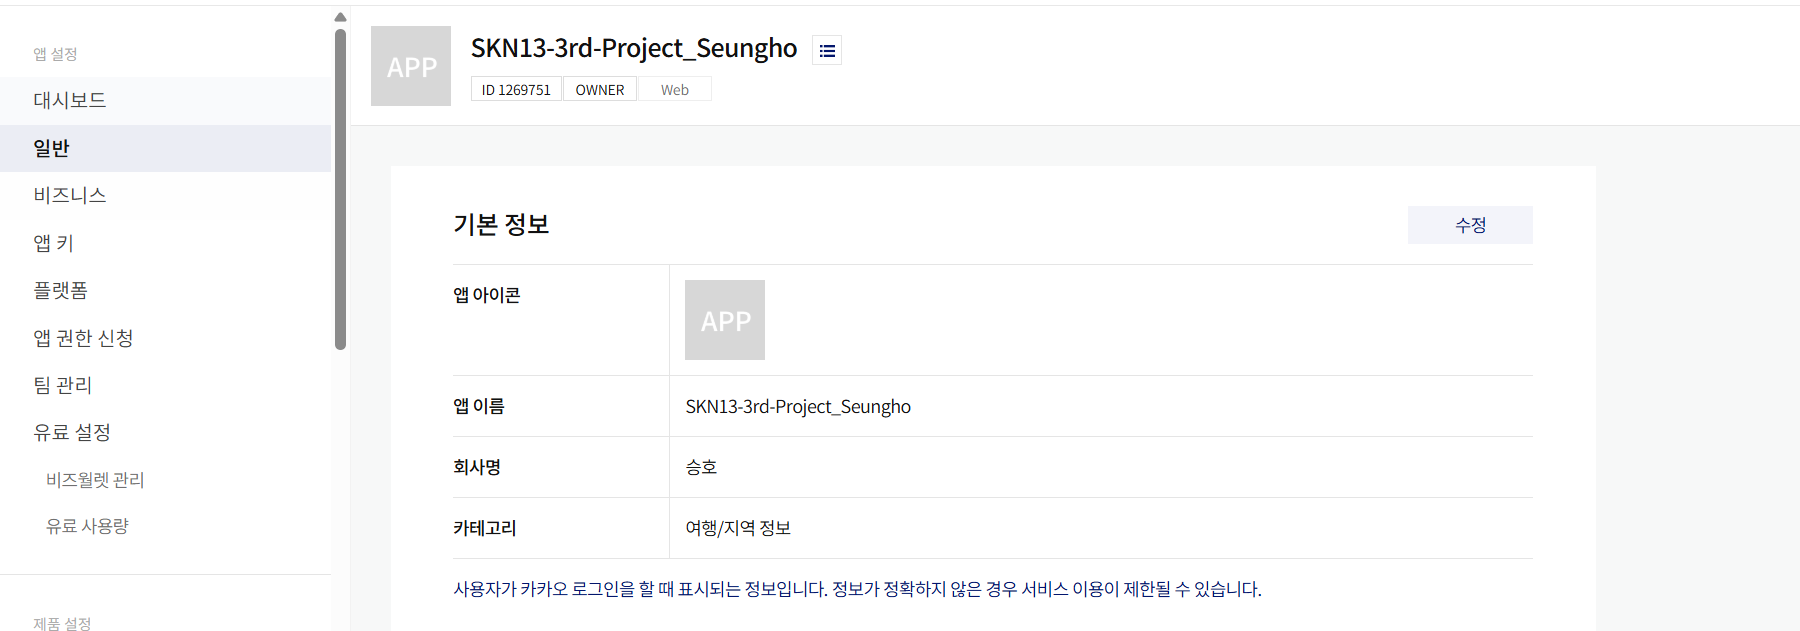

## 카카오맵 키 = 좌측 목록에서 앱 키 들어간 후 REST API 키 사용
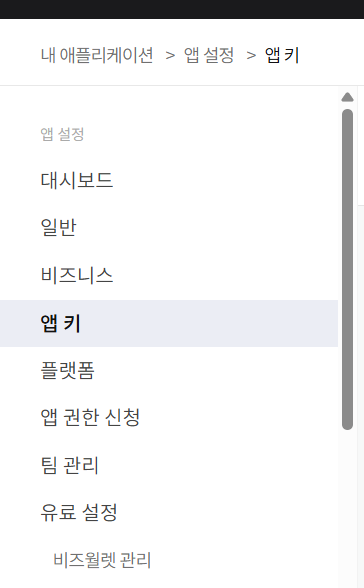

## kakao_key에 kakao map에서 발급받은 api키 넣고 OFF를 ON으로 변경
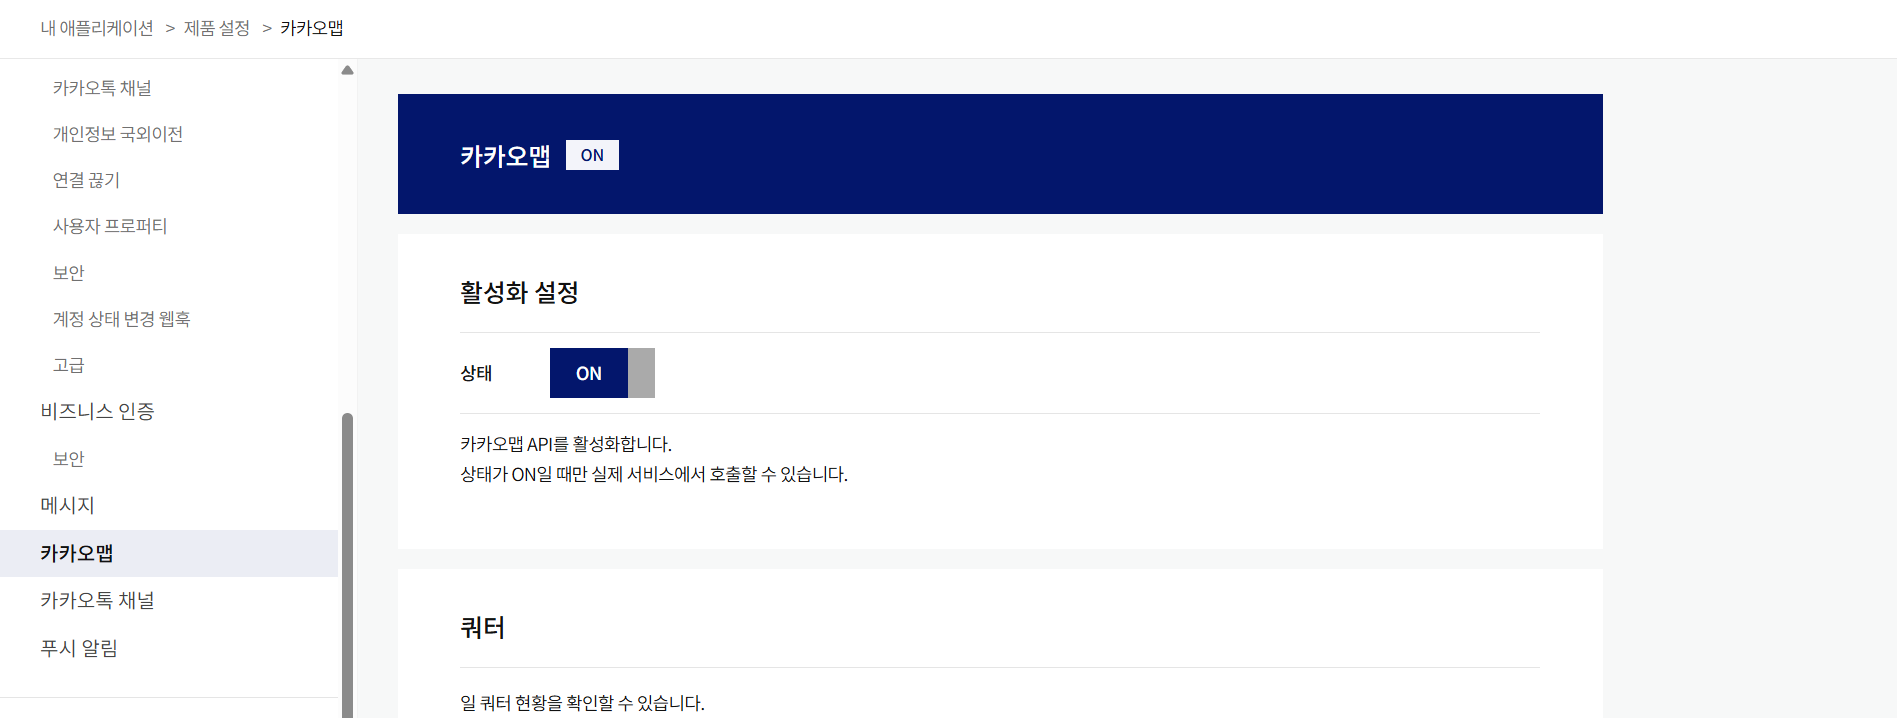

### 공공데이터 포털 -> 단기예보 검색 -> API 활용 신청
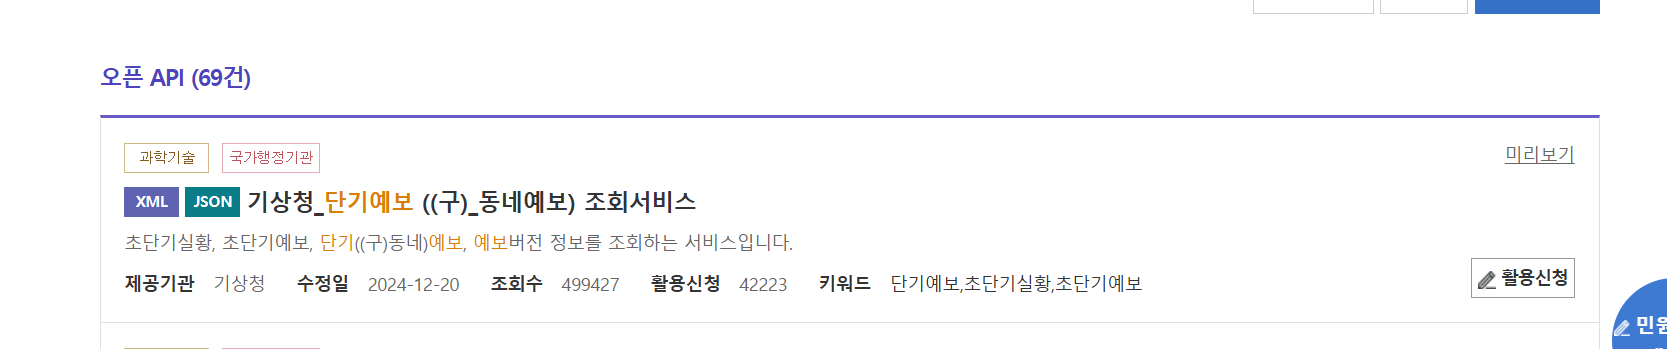

### 해당 화면까지 들어가서 일반인증키(DECODING) 키를 사용
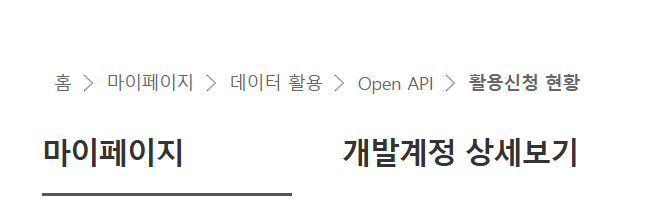

In [12]:
import os
from dotenv import load_dotenv

load_dotenv()

kakao_key = os.getenv("KAKAO_API_KEY")  
weather_key = os.getenv("WEATHER_API_KEY")     
address = "서울"                        

lat, lon = get_latlon_from_kakao(address, kakao_key)
if lat and lon:
    nx, ny = latlon_to_xy(lat, lon)
    print(f"{address} 격자 좌표: nx={nx}, ny={ny}")
    get_weather(nx, ny, weather_key)
else:
    print("주소 검색 실패")


SyntaxError: invalid syntax (2210775773.py, line 10)